In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from dgl.data import DGLDataset
import dgl
import dgl.function as fn
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
import scipy.io
from dgl.nn import HeteroGraphConv
from dgl.utils import expand_as_pair
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, BatchNorm1d as BN
import math
import torch.nn.init as init
import torch.utils.data as Data
import torch.nn.init as init

In [8]:
#%%
#Channel generation
#Channel generation
def generate_location(num_users):
    location_user = np.zeros((num_users,3))
    # location_user = np.array([[20,30,0],[20,-30,0]])
    # location_user = np.array([[10,30,0],[30,30,0],[10,-30,0],[30,-30,0]])
    
    for k in range(num_users):
        # x = np.random.uniform(5, 35)
        # y = np.random.uniform(-35, 35)
        x = np.random.uniform(20,30)
        # x = 25
        if k <= int(num_users/2)-1:
            y = np.random.uniform(20,45)
            # y = 25
        else:
            y = np.random.uniform(-45,-20)
            # y = -25
        z = 0
        coordinate_k = np.array([x, y, z])
        location_user[k, :] = coordinate_k
    return location_user

def generate_RISlocation(RIS_index,num_RIS):
    # location_RIS = np.empty([3])
    x = (RIS_index+1)*10
    y = 0
    z = 20
    coordinate = np.array([x, y, z])
    
    return coordinate
def path_loss_r(d):
    loss = 30 + 22.0 * np.log10(d)
    return loss


def path_loss_d(d):
    loss = 32.6 + 36.7 * np.log10(d)
    return loss


def generate_pathloss_aoa_aod(location_user, location_bs, location_irs):
    """
    :param location_user: array (num_user,2)
    :param location_bs: array (2,)
    :param location_irs: array (2,)
    :return: pathloss = (pathloss_irs_bs, pathloss_irs_user, pathloss_bs_user)
            cos_phi = (cos_phi_1, cos_phi_2, cos_phi_3)
    """
    num_user = location_user.shape[0]
    # ========bs-irs==============
    d0 = np.linalg.norm(location_bs - location_irs)
    pathloss_irs_bs = path_loss_r(d0)
    aoa_bs = ( location_irs[0] - location_bs[0]) / d0
    aod_irs_y = (location_bs[1]-location_irs[1]) / d0
    aod_irs_z = (location_bs[2]-location_irs[2]) / d0
    # =========irs-user=============
    pathloss_irs_user = []
    aoa_irs_y = []
    aoa_irs_z = []
    for k in range(num_user):
        d_k = np.linalg.norm(location_user[k] - location_irs)
        pathloss_irs_user.append(path_loss_r(d_k))
        aoa_irs_y_k = (location_user[k][1] - location_irs[1]) / d_k
        aoa_irs_z_k = (location_user[k][2] - location_irs[2]) / d_k
        aoa_irs_y.append(aoa_irs_y_k)
        aoa_irs_z.append(aoa_irs_z_k)
    aoa_irs_y = np.array(aoa_irs_y)
    aoa_irs_z = np.array(aoa_irs_z)

    # =========bs-user=============
    pathloss_bs_user = np.zeros([num_user, 1])
    for k in range(num_user):
        d_k = np.linalg.norm(location_user[k] - location_bs)
        pathloss_bs_user_k = path_loss_d(d_k)
        pathloss_bs_user[k, :] = pathloss_bs_user_k

    pathloss = (pathloss_irs_bs, np.array(pathloss_irs_user), np.array(pathloss_bs_user))
    aoa_aod = (aoa_bs, aod_irs_y, aod_irs_z, aoa_irs_y, aoa_irs_z)
    return pathloss, aoa_aod

def generate_channel(params_system, location_bs=np.array([0, 0, 0]), location_irs=np.array([0, 0, 0]),
                      location_user_initial=None, Rician_factor=10, scale_factor=100, num_samples=100,irs_Nh=10, num_RIS=1):
    # scale_factor: can be viewed as (downlink noise_power_dB- downlink Pt)

    (num_antenna_bs, num_elements_irs, num_user) = params_system 
        # location_irs2 = np.array([100, 0, 0])
        #channel BS to user
    
    for RIS_idx in range(num_RIS):
        location_irs = generate_RISlocation(RIS_idx,num_RIS)
        channel_bs_irs1, channel_bs_user_tmp, channel_irs_user1, set_location_user = [], [], [], []
        for ii in range(num_samples):
            if location_user_initial is None:
                location_user = generate_location(num_user)
                set_location_user.append(location_user)
            else:
                location_user = location_user_initial
                set_location_user.append(location_user)
        
            pathloss, aoa_aod = generate_pathloss_aoa_aod(location_user, location_bs, location_irs)
            (pathloss_irs_bs, pathloss_irs_user, pathloss_bs_user) = pathloss
            (aoa_bs, aod_irs_y, aod_irs_z, aoa_irs_y, aoa_irs_z) = aoa_aod
            
            pathloss_bs_user = pathloss_bs_user - scale_factor
            pathloss_irs_bs = pathloss_irs_bs - scale_factor / 2
            pathloss_irs_user = pathloss_irs_user - scale_factor / 2
            pathloss_bs_user = np.sqrt(10 ** ((-pathloss_bs_user) / 10))
            pathloss_irs_user = np.sqrt(10 ** ((-pathloss_irs_user) / 10))
            pathloss_irs_bs = np.sqrt(10 ** ((-pathloss_irs_bs) / 10))
            
            # tmp:(num_antenna_bs,num_user) channel between BS and user
            if RIS_idx == 0:
                tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_user]) \
                      + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_user])
                tmp = tmp * pathloss_bs_user.reshape(1, num_user)
                channel_bs_user_tmp.append(tmp)
                
            # tmp: (num_antenna_bs,num_elements_irs) channel between IRS and BS
            tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_elements_irs]) \
                  + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_elements_irs])
            a_bs = np.exp(1j * np.pi * aoa_bs * np.arange(num_antenna_bs))
            a_bs = np.reshape(a_bs, [num_antenna_bs, 1])
    
            i1 = np.mod(np.arange(num_elements_irs),irs_Nh)
            i2 = np.floor(np.arange(num_elements_irs)/irs_Nh)
            a_irs_bs = np.exp(1j * np.pi * (i1*aod_irs_y+i2*aod_irs_z))
            a_irs_bs =  np.reshape(a_irs_bs, [num_elements_irs, 1])
            los_irs_bs = a_bs @ np.transpose(a_irs_bs.conjugate())
            tmp = np.sqrt(Rician_factor / (1 + Rician_factor)) * los_irs_bs + np.sqrt(1/(1 + Rician_factor)) * tmp
            tmp = tmp * pathloss_irs_bs
            channel_bs_irs1.append(tmp)
            
            # tmp:(num_elements_irs,num_user) channel between IRS and user
            tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_elements_irs, num_user]) \
                  + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_elements_irs, num_user])
            for k in range(num_user):
                a_irs_user = np.exp(1j * np.pi * (i1 * aoa_irs_y[k] + i2 * aoa_irs_z[k]))
                tmp[:, k] = np.sqrt(Rician_factor/(1+Rician_factor))*a_irs_user+np.sqrt(1/(1+Rician_factor))*tmp[:, k]
                tmp[:, k] = tmp[:, k] * pathloss_irs_user[k]
            channel_irs_user1.append(tmp)
             
        aa = 1
        if RIS_idx == 0:
            channel_bs_user = channel_bs_user_tmp
            channel_irs_user = np.array(channel_irs_user1)
            channel_bs_irs = np.array(channel_bs_irs1)
        else:
            channel_irs_user = np.concatenate((channel_irs_user,np.array(channel_irs_user1)),axis=1)
            channel_bs_irs = np.concatenate((channel_bs_irs,np.array(channel_bs_irs1)),axis=2)
        
    # channel_irs_user = np.concatenate((np.array(channel_irs_user1),np.array(channel_irs_user2)),axis=1)
    # channel_bs_irs = np.concatenate((np.array(channel_bs_irs1),np.array(channel_bs_irs2)),axis=2)
    channels = (np.array(channel_bs_user), channel_irs_user, channel_bs_irs)
    return channels, set_location_user



def channel_complex2real(channels):
    channel_bs_user, channel_irs_user, channel_bs_irs = channels
    (num_sample, num_antenna_bs, num_elements_irs) = channel_bs_irs.shape
    num_user = channel_irs_user.shape[2]

    A_T_real = np.zeros([num_sample, 2 * num_elements_irs, 2 * num_antenna_bs, num_user])
    # Hd_real = np.zeros([num_sample, 2 * num_antenna_bs, num_user])
    set_channel_combine_irs = np.zeros([num_sample, num_antenna_bs, num_elements_irs, num_user], dtype=complex)

    for kk in range(num_user):
        channel_irs_user_k = channel_irs_user[:, :, kk]
        channel_combine_irs = channel_bs_irs * channel_irs_user_k.reshape(num_sample, 1, num_elements_irs)
        set_channel_combine_irs[:, :, :, kk] = channel_combine_irs
        A_tmp_tran = np.transpose(channel_combine_irs, (0, 2, 1))
        A_tmp_real1 = np.concatenate([A_tmp_tran.real, A_tmp_tran.imag], axis=2)
        A_tmp_real2 = np.concatenate([-A_tmp_tran.imag, A_tmp_tran.real], axis=2)
        A_tmp_real = np.concatenate([A_tmp_real1, A_tmp_real2], axis=1)
        A_T_real[:, :, :, kk] = A_tmp_real

    Hd_real = np.concatenate([channel_bs_user.real, channel_bs_user.imag], axis=1)

    return A_T_real, Hd_real, np.array(set_channel_combine_irs)
#%%
class RIS_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.Phasenet = nn.Sequential(
                        nn.Conv2d(2*K,64,4,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,4,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Flatten(),
                        nn.Linear(21760,256),
                        nn.ReLU(),
                        nn.BatchNorm1d(256),
                        nn.Linear(256,3*M),
                        nn.Sigmoid()
                        )
#         for m in self.Phasenet.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
                
        self.Beamnet = nn.Sequential(
                        nn.Linear(2*Nt*K, 256),
                        nn.ReLU(),
                        nn.BatchNorm1d(256),
                        nn.Linear(256,256),
                        nn.ReLU(),
                        nn.BatchNorm1d(256),
                        nn.Linear(256,2*Nt*K))
#         for m in self.Beamnet.modules():
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)

    def forward(self,x,H,G):
        batch = H.shape[0]
        phase = self.Phasenet(x)
        phase_T = phase[:,:M]
        phase_R = phase[:,M:2*M]
        phase_T = torch.reshape(phase_T,(batch,-1))
        phase_R = torch.reshape(phase_R,(batch,-1))
        
        amplitude_T = phase[:,2*M:]
        amplitude_T = torch.reshape(amplitude_T,(batch,-1))
        amplitude_R = 1 - amplitude_T
        
        theta_T = torch.exp(1j*2*math.pi*phase_T)
        theta_T = torch.sqrt(amplitude_T)*theta_T
        
        theta_R = torch.exp(1j*2*math.pi*phase_R)
        theta_R = torch.sqrt(amplitude_R)*theta_R
        
        phi_T = torch.diag_embed(theta_T)
        phi_R = torch.diag_embed(theta_R)
        
        temp_T = torch.matmul(H,phi_T)
        temp_R = torch.matmul(H,phi_R)
        
        CSI_T = torch.matmul(temp_T,G[:,:,:int(K/2)])
        CSI_R = torch.matmul(temp_R,G[:,:,int(K/2):])
        CSI = torch.concat((CSI_T,CSI_R),dim=2)
        CSI_real = torch.view_as_real(CSI)
        CSI_real = torch.reshape(CSI_real,(batch,Nt*2*K))
        
        beam = self.Beamnet(CSI_real)
        aa = 1
        return phi_T, phi_R, beam
#%%
def sr_loss(beam,phi_T, phi_R,H,G):
    #calculate sumrate of the system
    #phase: predicted phase of RIS
    #H,G: channel links
    #beam: predicted beamforming matrix 
    
    batch = H.shape[0]
    Nt = H.shape[1]
    # print(G.shape)
    K = G.shape[2] #num of user
    
   
    
    temp = torch.reshape(beam,(batch,K,Nt,2))
    BF_matrix = torch.view_as_complex(temp)
    BF_matrix = torch.transpose(BF_matrix,1,2)
    
    
    mean = (abs(BF_matrix)**2/2).mean()     
    beam_complex = math.sqrt(Pmax)*BF_matrix/torch.sqrt(mean*Nt*K)

    #transpose variables to the correct shape
    
    H = torch.transpose(H,1,2)
    G = torch.transpose(G,1,2)
    
    sum_rate = 0
    rate = torch.zeros(batch,K)
    # T region user
    for i in range(int(K/2)):
        interference = 0
        gk = G[:,i,:].unsqueeze(1) #channel from RIS to the k-th user
        temp = torch.matmul(gk,phi_T)
        temp = torch.matmul(temp,H)
        
        for j in range(K):
            if i!=j:            
                interference_temp = torch.matmul((temp),beam_complex[:,:,j].unsqueeze(2)).squeeze() #effective channel for the k-th user
                interference += torch.square(torch.abs(interference_temp))
                
        received_snr = torch.matmul(temp,beam_complex[:,:,i].unsqueeze(2)).squeeze()
        received_snr = torch.square(torch.abs(received_snr))
        sum_rate += torch.log2(1 + torch.div(received_snr,(interference+1))) 
        rate[:,i] = torch.log2(1 + torch.div(received_snr,(interference+1))) 
        
    #R region user
    
    for i in range(int(K/2),K):
        interference = 0
        gk = G[:,i,:].unsqueeze(1) #channel from RIS to the k-th user
        temp = torch.matmul(gk,phi_R)
        temp = torch.matmul(temp,H)
        
        for j in range(K):
            if i!=j:            
                interference_temp = torch.matmul((temp),beam_complex[:,:,j].unsqueeze(2)).squeeze() #effective channel for the k-th user
                interference += torch.square(torch.abs(interference_temp))
                
        received_snr = torch.matmul(temp,beam_complex[:,:,i].unsqueeze(2)).squeeze()
        received_snr = torch.square(torch.abs(received_snr))
        sum_rate += torch.log2(1 + torch.div(received_snr,(interference+1))) 
        rate[:,i] = torch.log2(1 + torch.div(received_snr,(interference+1))) 
        
    
                
    return torch.neg(torch.mean(sum_rate))
#%%
def train(model,device):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for  feature, H,G in (train_loader):
        batch = H.shape[0]
        feature = feature.to(device)
        H = H.to(device)
        G = G.to(device)
        
        optimizer.zero_grad()
        phi_T, phi_R, beam = model(feature,H,G)
        
        loss = sr_loss(beam,phi_T, phi_R,H,G)
        loss.backward()
        
        loss_all += loss.item() * batch
        optimizer.step()
    return loss_all / len(train_loader.dataset)
#%%
def test(loader):
    # model.eval()
    loss_all = 0
    for  feature, H,G in (loader):
        batch = H.shape[0]
        feature = feature.to(device)
        H = H.to(device)
        G = G.to(device)
        
        phi_T, phi_R, beam = model(feature,H,G)
        
        loss = sr_loss(beam,phi_T, phi_R,H,G)      
        loss_all += loss.item() * batch
#         optimizer.step()
        
    return loss_all / len(loader.dataset), beam

In [9]:
#Build graph dataset
class PCDataset(DGLDataset):
    def __init__(self, H, G, Nt, N_RIS, num_RIS, K):
        num_sample = H.shape[0]
        # self.H = torch.reshape(torch.view_as_real(H),(num_sample,Nt,2*N_RIS))
        # self.G = torch.reshape(torch.view_as_real(G),(num_sample,N_RIS,2*K))
        
        self.H = H 
        self.G = G
        self.num_RIS = num_RIS
        # self.D = D
        # self.D_real = torch.view_as_real(D) 
        self.H_real = torch.view_as_real(H)
        self.G_real = torch.view_as_real(G)
        # self.cross = torch.tensor(cross, dtype = torch.float)
        self.K = K
        self.Nt = Nt
        self.N_RIS = N_RIS
        self.get_cg()
        super().__init__(name='beamforming')
        
        
    def build_graph(self, idx):

        graph = dgl.heterograph({('RIS', 'RIS-UE', 'UE') : self.RIS_UE,('UE', 'UE-RIS', 'RIS') : self.UE_RIS})
        
        UE_node_ft = torch.ones((self.K,1))
        RIS_node_ft = torch.ones((self.N_RIS*self.num_RIS,1))
        
        edge_ft_RIS_UE = torch.zeros((self.N_RIS*self.num_RIS*self.K,2*self.Nt))
        count = 0
        for k in range(K):
            for i in range(self.N_RIS*self.num_RIS):
                temp = torch.matmul(self.H[idx,:,i].unsqueeze(1),self.G[idx,i,k].unsqueeze(0).unsqueeze(1))
                temp = torch.view_as_real(temp)
                edge_ft_RIS_UE[count] = torch.reshape(temp,(2*Nt,-1)).squeeze()
                count += 1
        
        edge_ft_UE_RIS = torch.zeros((self.N_RIS*self.num_RIS*self.K,2*self.Nt))
        count = 0
        for i in range(self.N_RIS*self.num_RIS):
            for k in range(K):
                temp = torch.matmul(self.H[idx,:,i].unsqueeze(1),self.G[idx,i,k].unsqueeze(0).unsqueeze(1))
                temp = torch.view_as_real(temp)
                edge_ft_UE_RIS[count] = torch.reshape(temp,(2*Nt,-1)).squeeze()
                count += 1
    
            
        graph.nodes['UE'].data['feat'] = UE_node_ft
        graph.nodes['RIS'].data['feat'] = RIS_node_ft
        
        graph.edges['RIS-UE'].data['feat'] = edge_ft_RIS_UE
        graph.edges['UE-RIS'].data['feat'] = edge_ft_UE_RIS

        return graph
    
    def get_cg(self):
        ## The graph is a fully connected bipartite graph
        self.BS_RIS = []; self.RIS_BS = []
        self.UE_RIS = []; self.RIS_UE = []
        self.BS_UE = []; self.UE_BS = []
        for i in range(0,self.K):
            for j in range(0,self.num_RIS*self.N_RIS):
                self.UE_RIS.append([i,j])
                self.RIS_UE.append([j,i])
        # for i in range(0,self.Nt):
        #     for j in range(0,self.K):
        #         self.BS_UE.append([i,j])
        #         self.UE_BS.append([j,i])
                    
    def __len__(self):
        'Denotes the total number of samples'
        return self.H.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.graph_list[index], self.H[index], self.G[index]

    def process(self):
        n = self.H.shape[0]
        self.graph_list = []
        for i in range(n):
            graph = self.build_graph(i)
            self.graph_list.append(graph)
#%%
def collate(samples):
    '''DGL collate function'''
    graphs, H, G = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.stack(H), torch.stack(G)

In [10]:
##Graph neural network model for RIS system

def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv(nn.Module):
    def __init__(self, node_dim, feature_dim, **kwargs):
        super(EdgeConv, self).__init__()
        self.lin = MLP([node_dim, node_dim])
        self.res_lin = MLP([node_dim, feature_dim])
        self.bn = BN(32)
        #self.reset_parameters()

    def concat_message_function(self, edges):
        concat_message = torch.cat([edges.src['hid'], edges.dst['hid'], edges.data['feat']], axis = 1)
        
        return {'out': self.lin(concat_message)}
    
    def forward(self, g, inputs):
        with g.local_scope():
            feat_src, feat_dst = expand_as_pair(inputs, g)
            g.srcdata['hid'] = feat_src
            g.dstdata['hid'] = feat_dst
            
            g.apply_edges(self.concat_message_function)
            # g.edata['out'] = self.lin(g.edata['out'])
            g.update_all(fn.copy_e('out', 'm'),
                         fn.mean('m', 'hid'))
            # return g.dstdata['hid'] + self.res_lin(feat_dst)
            return self.res_lin(g.dstdata['hid'])
    
#%%
class RGCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_dim = 256
        
        self.conv1 = HeteroGraphConv({rel:EdgeConv(34,self.feature_dim)
                                            for rel in ['BS-RIS', 'RIS-BS', 'RIS-UE', 'UE-RIS']}, aggregate='sum')
        self.conv2= HeteroGraphConv({rel:EdgeConv(576,self.feature_dim)
                                            for rel in ['BS-RIS', 'RIS-BS', 'RIS-UE', 'UE-RIS']}, aggregate='sum')
        self.conv3 = HeteroGraphConv({rel:EdgeConv(576,self.feature_dim)
                                            for rel in ['BS-RIS', 'RIS-BS', 'RIS-UE', 'UE-RIS']}, aggregate='sum')
        # self.conv4 = HeteroGraphConv({rel:EdgeConv(576,self.feature_dim)
        #                                     for rel in ['BS-RIS', 'RIS-BS', 'RIS-UE', 'UE-RIS']}, aggregate='sum')
        # self.mlp_BS = MLP([32, 64])
        # self.mlp_BS = Seq(*[self.mlp_BS, Seq(Lin(64, 2*Nt), Sigmoid())])
        
        # self.mlp_RIS = MLP([32, 16])
        # self.mlp_RIS = Seq(*[self.mlp_RIS, Seq(Lin(16, 2), Sigmoid())])
        
        self.mlp_BS = nn.Sequential(
                    nn.Linear(self.feature_dim, 256),
                    nn.ReLU(),
                    nn.BatchNorm1d(256),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    nn.BatchNorm1d(256),
                    nn.Linear(256, Nt*2)
                    # nn.Tanh()
                    )
        self.mlp_RIS = nn.Sequential(
                    nn.Linear(self.feature_dim, 64),
                    nn.Sigmoid(),
                    nn.BatchNorm1d(64),
                    nn.Linear(64, 2),
                    nn.Sigmoid()
                )
        self.mlp_power = nn.Sequential(
                    nn.Linear(self.feature_dim, 64),
                    nn.Sigmoid(),
                    nn.BatchNorm1d(64),
                    nn.Linear(64, 1),
                    nn.Sigmoid()
                )

    def intermediate_predictions(self, node_features):
        beam = self.mlp_BS(node_features['UE'])
        phase = self.mlp_RIS(node_features['RIS'])
        amplitude = self.mlp_power(node_features['RIS'])
        return beam, phase, amplitude
    
    def forward(self, g, inputs):
        out = self.conv1(g, inputs)
        
        beam, phase, amplitude = self.intermediate_predictions(out)
        out['UE'] = torch.cat([out['UE'], beam], dim=1)
        # out['RIS'] = torch.cat([out['RIS'], phase, amplitude], dim=1)
        
        out = self.conv2(g, out)
        beam, phase, amplitude = self.intermediate_predictions(out)
        out['UE'] = torch.cat([out['UE'], beam], dim=1)
        # out['RIS'] = torch.cat([out['RIS'], phase, amplitude], dim=1)
        
        out = self.conv3(g, out)
        # beam, phase, amplitude = self.intermediate_predictions(out)
        # out['UE'] = torch.cat([out['UE'], beam], dim=1)
        
        # out = self.conv4(g, out)
        
        beam = self.mlp_BS(out['UE'])
        phase = self.mlp_RIS(out['RIS'])
        amplitude = self.mlp_power(out['RIS'])
        return beam, phase, amplitude

In [11]:
#Loss function for beamforming task
def sr_loss(beam,phase, amplitude,H,G,N_RIS,num_RIS):
    #calculate sumrate of the system
    #phase: predicted phase of RIS
    #H,G: channel links
    #beam: predicted beamforming matrix 
    
    batch = H.shape[0]
    Nt = H.shape[1]
    # print(G.shape)
    K = G.shape[2] #num of user
    
    # print(batch)
    # print(Nt)
    # print(K)
    
    amplitude_T = amplitude
    
    # phase_T = phase[:,:N_RIS]
    # phase_R = phase[:,N_RIS:]
    
    phase_T = phase[:,0]
    phase_R = phase[:,1]
    
    phase_T = torch.reshape(phase_T,(batch,-1))
    phase_R = torch.reshape(phase_R,(batch,-1))
    amplitude_T = torch.reshape(amplitude_T,(batch,-1))
    amplitude_R = 1 - amplitude_T
    # phase = torch.reshape(phase,(batch,-1))
    # amplitude_T = phase[::,]
    amplitude_T = torch.sqrt(amplitude_T)
    amplitude_R = torch.sqrt(amplitude_R)
    
    temp = torch.reshape(beam,(batch,K,Nt,2))
    BF_matrix = torch.view_as_complex(temp)
    BF_matrix = torch.transpose(BF_matrix,1,2)
    
    # BF_matrix = torch.nn.functional.normalize(BF_matrix,dim=2) #power normalization
    # beam_complex = BF_matrix*math.sqrt(Pmax/K)
    
    # beam_complex = BF_matrix*math.sqrt(Pmax/Nt)
    
    mean = (abs(BF_matrix)**2).mean()     
    beam_complex = math.sqrt(Pmax)*BF_matrix/torch.sqrt(mean*Nt)
    
    
    
    #transpose variables to the correct shape
    
    H = torch.transpose(H,1,2)
    G = torch.transpose(G,1,2)

    theta_T = torch.exp(1j*2*math.pi*phase_T) #reflecting vector
    # theta_T = torch.sqrt(amplitude_T)*theta_T
     
    theta_R = torch.exp(1j*2*math.pi*phase_R) #reflecting vector
    # theta_R = amplitude_R*theta_R
    
    phi_T = torch.diag_embed(theta_T)
    phi_R = torch.diag_embed(theta_R)
    
    g = torch.zeros(batch,Nt,K, dtype=torch.complex64,device=device)
    
    # sum_rate = rate_calculator(H, G, g, beam_complex, Nt, K, N_RIS, num_RIS, theta_T, theta_R, amplitude_T, amplitude_R, 1)
    sum_rate = 0
    rate = torch.zeros(batch,K)
    # T region user
    for i in range(int(K/2)):
        interference = 0
        gk = G[:,i,:].unsqueeze(1) #channel from RIS to the k-th user
        temp = torch.matmul(gk,phi_T)
        temp = torch.matmul(temp,H)
        
        for j in range(K):
            if i!=j:            
                interference_temp = torch.matmul((temp),beam_complex[:,:,j].unsqueeze(2)).squeeze() #effective channel for the k-th user
                interference += torch.square(torch.abs(interference_temp))
                
        received_snr = torch.matmul(temp,beam_complex[:,:,i].unsqueeze(2)).squeeze()
        received_snr = torch.square(torch.abs(received_snr))
        sum_rate += torch.log2(1 + torch.div(received_snr,(interference+1))) 
        rate[:,i] = torch.log2(1 + torch.div(received_snr,(interference+1))) 
        
    #R region user
    
    for i in range(int(K/2),K):
        interference = 0
        gk = G[:,i,:].unsqueeze(1) #channel from RIS to the k-th user
        temp = torch.matmul(gk,phi_R)
        temp = torch.matmul(temp,H)
        
        for j in range(K):
            if i!=j:            
                interference_temp = torch.matmul((temp),beam_complex[:,:,j].unsqueeze(2)).squeeze() #effective channel for the k-th user
                interference += torch.square(torch.abs(interference_temp))
                
        received_snr = torch.matmul(temp,beam_complex[:,:,i].unsqueeze(2)).squeeze()
        received_snr = torch.square(torch.abs(received_snr))
        sum_rate += torch.log2(1 + torch.div(received_snr,(interference+1))) 
        rate[:,i] = torch.log2(1 + torch.div(received_snr,(interference+1))) 
        
    
                
    return torch.neg(torch.mean(sum_rate))

In [12]:
#%%
def train(model,device):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (g, H, G) in enumerate(train_loader):
        #data = data.to(device)
        batch = H.shape[0]
        g = g.to(device)
        H = H.to(device)
        
        
        G = G.to(device)
        # D = D.to(device)
        optimizer.zero_grad()
        
        user_feats = g.nodes['UE'].data['feat']
        RIS_feats = g.nodes['RIS'].data['feat']
        
        node_features = {'UE': user_feats, 'RIS':RIS_feats}
        beam, phase, amplitude = model(g, node_features)
        
        loss = sr_loss(beam, phase, amplitude, H, G, N_RIS, num_RIS)
        loss.backward()

        loss_all += loss.item() * batch
        optimizer.step()
    return loss_all / len(train_loader.dataset)
#%%
def test(loader):
    # model.eval()
    correct = 0
    for (g, H, G) in loader:
        batch = H.shape[0]
        g = g.to(device)
        H = H.to(device)
        G = G.to(device)
       
        user_feats = g.nodes['UE'].data['feat']
        RIS_feats = g.nodes['RIS'].data['feat']
        
        node_features = {'UE': user_feats, 'RIS':RIS_feats}
        beam, phase, amplitude = model(g, node_features)
        # print(G.shape)
        loss = sr_loss(beam, phase, amplitude, H, G, N_RIS, num_RIS)
        correct += loss.item() * batch
    return correct / len(loader.dataset), beam, phase, amplitude

In [13]:
#system parameter
Nt = 16 #Number of BS antenna
N_RIS = 4 #Number of RIS elements
K = 8 #number of user
num_RIS = 4 #Number of RISs
train_sample = 1200
Pmax = 1
train_num = 1000
#%%
num_antenna_bs, N_RIS, K, num_sample = Nt, N_RIS, K, train_sample
params_system = (num_antenna_bs, N_RIS, K)
noise_power_db, Rician_factor = -100, 2
location_user = None

In [6]:
#generate channel and create dataset
channels, set_location_user = generate_channel(params_system,
                                               num_samples=num_sample, location_user_initial=location_user,
                                               Rician_factor=Rician_factor,num_RIS=num_RIS)

#%%
G_train = torch.tensor(channels[1])[:,:N_RIS*num_RIS,:]
H_train = torch.tensor(channels[2])[:,:,:N_RIS*num_RIS]


H_train = H_train.type(torch.complex64)
G_train = G_train.type(torch.complex64)


#%%
batch_size = 64
val_data = PCDataset(H_train[train_num:], G_train[train_num:], Nt, N_RIS, num_RIS, K)
val_loader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate)
#%%
train_data = PCDataset(H_train[0:train_num], G_train[0:train_num], Nt, N_RIS, num_RIS, K)
train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)

NameError: name 'params_system' is not defined

In [14]:
device = torch.device('cuda' if torch.cuda.is_available()==True else 'cpu')
model = RGCN().to(device)
#%%
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
device = torch.device('cuda')
model = model.to(device)

### Training

In [76]:
i = 0
val_rate = 0
record = []
for epoch in range(0, 50):
    
    # if epoch % 5 == 0:
    train_rate = train(model,device)
    val_rate, a,b,c = test(val_loader)
    
    print('Epoch {:03d}, Train Rate: {:.4f}, Val rate: {:.4f}'.format(
        epoch, train_rate, val_rate))
    record.append(train_rate)
    scheduler.step()

In [ ]:
#save the trained model
torch.save(model.state_dict(),'RIS_HetnetGNN_train16RIS_16x8MIMO_10000sample_ver4_test5pt')

### Testing 

In [15]:
#Load the trained model
model.load_state_dict(torch.load('RIS_HetnetGNN_train16RIS_16x8MIMO_10000sample_ver4_test4.pt'))

<All keys matched successfully>

In [18]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

In [65]:
#system parameter
Nt = 16 #Number of BS antenna
 
K = 8 #number of user
num_RIS = 4 #Number of RISs

N_RIS_range = list(frange(4,17,2))#Number of RIS elements

test_sample = 100
Pmax = 1
num_antenna_bs, N_RIS, K, num_sample = Nt, N_RIS, K, test_sample

noise_power_db, Rician_factor = -100, 2
location_user = None
test_rate_array = []
for n in range(0, len(N_RIS_range)):
    
    N_RIS = N_RIS_range[n]
    params_system = (num_antenna_bs, N_RIS, K)
    channels, set_location_user = generate_channel(params_system,
                                                   num_samples=num_sample, location_user_initial=location_user,
                                                   Rician_factor=Rician_factor,num_RIS=num_RIS)


    G_test = torch.tensor(channels[1])[:,:N_RIS*num_RIS,:]
    H_test= torch.tensor(channels[2])[:,:,:N_RIS*num_RIS]


    H_test = H_test.type(torch.complex64)
    G_test = G_test.type(torch.complex64)

    test_data = PCDataset(H_test, G_test, Nt, N_RIS, num_RIS, K)
    
    test_loader = DataLoader(test_data, test_sample, shuffle=False, collate_fn=collate)
    test_rate, beam, phase, amplitude = test(test_loader)
    
    test_rate_array.append(-test_rate)

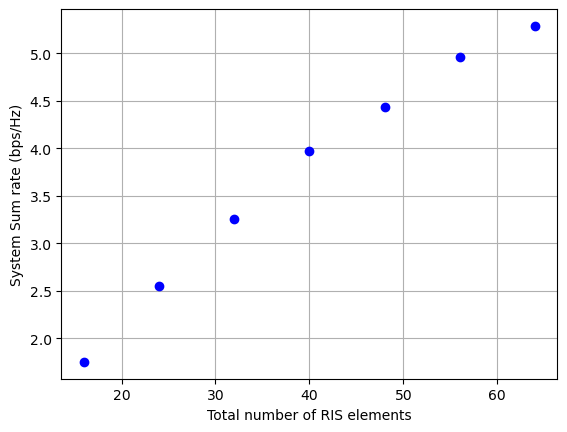

In [67]:
#Plot the result

import matplotlib.pyplot as plt

Total_N_RIS = [x*num_RIS for x in N_RIS_range]
plt.plot(Total_N_RIS, test_rate_array, 'bo',label='HetGNN')
plt.yscale('linear')
plt.xlabel('Total number of RIS elements')
plt.ylabel('System Sum rate (bps/Hz)')
plt.grid()
